# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array
from fractal.perc import FractalImage

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
tf.get_logger().setLevel('ERROR')

### Model description

- Model architecture: XCeption
- Fractal module used: with Percolation 
- Number of layers tuned: 1

### Load the ISIC Archive dataset

In [4]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [5]:
class LesionClassifier(tf.keras.Model):
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(
            width=self.TARGET_WIDTH,
            height=self.TARGET_HEIGHT
        )
        self.rescale = tf.keras.layers.Rescaling(scale=1./255)
        
        self.o_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.o_model.layers:
            if layer.name in ['block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False 
        
        self.f_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.f_model.layers:
            if layer.name in ['block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False   
        
        self.concatenate = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)
        
        f_outputs = self.fractal_image(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)
        
        outputs = self.concatenate([f_outputs, o_outputs])
        outputs = self.dense(outputs)
        
        return outputs

In [6]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [9]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 1.2405 - accuracy: 0.6628
Epoch 1: val_loss improved from inf to 1.17654, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6656s 7s/step - loss: 1.2405 - accuracy: 0.6628 - val_loss: 1.1765 - val_accuracy: 0.6689
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.1732 - accuracy: 0.6678
Epoch 2: val_loss improved from 1.17654 to 1.16044, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7652s 8s/step - loss: 1.1732 - accuracy: 0.6678 - val_loss: 1.1604 - val_accuracy: 0.6715
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.6731
Epoch 3: val_loss improved from 1.16044 to 1.14468, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7422s 8s/step - loss: 1.1564 - accuracy: 0.6731 - val_loss: 1.1447 - val_accuracy: 0.6781
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.1267 - accuracy: 0.6764
Epoch 4: val_loss improved from 1.14468 to 1.11450, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8306s 9s/step - loss: 1.1267 - accuracy: 0.6764 - val_loss: 1.1145 - val_accuracy: 0.6802
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.0892 - accuracy: 0.6789
Epoch 5: val_loss improved from 1.11450 to 1.09915, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7680s 8s/step - loss: 1.0892 - accuracy: 0.6789 - val_loss: 1.0992 - val_accuracy: 0.6786
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.6791
Epoch 6: val_loss improved from 1.09915 to 1.06053, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8271s 9s/step - loss: 1.0686 - accuracy: 0.6791 - val_loss: 1.0605 - val_accuracy: 0.6808
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.0447 - accuracy: 0.6807
Epoch 7: val_loss improved from 1.06053 to 1.03772, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8669s 9s/step - loss: 1.0447 - accuracy: 0.6807 - val_loss: 1.0377 - val_accuracy: 0.6833
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.0339 - accuracy: 0.6812
Epoch 8: val_loss did not improve from 1.03772
947/947 [==============================] - 9986s 11s/step - loss: 1.0339 - accuracy: 0.6812 - val_loss: 1.0410 - val_accuracy: 0.6806
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.0218 - accuracy: 0.6826
Epoch 9: val_loss improved from 1.03772 to 1.00875, saving model to checkpoints/model.ckpt


947/947 [==============================] - 10054s 11s/step - loss: 1.0218 - accuracy: 0.6826 - val_loss: 1.0087 - val_accuracy: 0.6856
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.6864
Epoch 10: val_loss did not improve from 1.00875
947/947 [==============================] - 9391s 10s/step - loss: 1.0130 - accuracy: 0.6864 - val_loss: 1.0657 - val_accuracy: 0.6800
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 1.0016 - accuracy: 0.6852
Epoch 11: val_loss improved from 1.00875 to 0.99284, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8576s 9s/step - loss: 1.0016 - accuracy: 0.6852 - val_loss: 0.9928 - val_accuracy: 0.6863
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 0.9971 - accuracy: 0.6883
Epoch 12: val_loss did not improve from 0.99284
947/947 [==============================] - 7851s 8s/step - loss: 0.9971 - accuracy: 0.6883 - val_loss: 0.9939 - val_accuracy: 0.6849
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.6883
Epoch 13: val_loss improved from 0.99284 to 0.98468, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6881s 7s/step - loss: 0.9922 - accuracy: 0.6883 - val_loss: 0.9847 - val_accuracy: 0.6948
Epoch 14/30
947/947 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.6870
Epoch 14: val_loss improved from 0.98468 to 0.97156, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6054s 6s/step - loss: 0.9883 - accuracy: 0.6870 - val_loss: 0.9716 - val_accuracy: 0.6889
Epoch 15/30
947/947 [==============================] - ETA: 0s - loss: 0.9822 - accuracy: 0.6890
Epoch 15: val_loss did not improve from 0.97156
947/947 [==============================] - 5586s 6s/step - loss: 0.9822 - accuracy: 0.6890 - val_loss: 0.9757 - val_accuracy: 0.6940
Epoch 16/30
947/947 [==============================] - ETA: 0s - loss: 0.9778 - accuracy: 0.6895
Epoch 16: val_loss improved from 0.97156 to 0.96129, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6456s 7s/step - loss: 0.9778 - accuracy: 0.6895 - val_loss: 0.9613 - val_accuracy: 0.6942
Epoch 17/30
947/947 [==============================] - ETA: 0s - loss: 0.9744 - accuracy: 0.6906
Epoch 17: val_loss did not improve from 0.96129
947/947 [==============================] - 9256s 10s/step - loss: 0.9744 - accuracy: 0.6906 - val_loss: 0.9689 - val_accuracy: 0.6883
Epoch 18/30
947/947 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.6890 
Epoch 18: val_loss improved from 0.96129 to 0.95863, saving model to checkpoints/model.ckpt


947/947 [==============================] - 12230s 13s/step - loss: 0.9741 - accuracy: 0.6890 - val_loss: 0.9586 - val_accuracy: 0.6928
Epoch 19/30
947/947 [==============================] - ETA: 0s - loss: 0.9647 - accuracy: 0.6937
Epoch 19: val_loss improved from 0.95863 to 0.95673, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7594s 8s/step - loss: 0.9647 - accuracy: 0.6937 - val_loss: 0.9567 - val_accuracy: 0.6926
Epoch 20/30
947/947 [==============================] - ETA: 0s - loss: 0.9609 - accuracy: 0.6927
Epoch 20: val_loss did not improve from 0.95673
947/947 [==============================] - 7333s 8s/step - loss: 0.9609 - accuracy: 0.6927 - val_loss: 0.9582 - val_accuracy: 0.6925
Epoch 21/30
947/947 [==============================] - ETA: 0s - loss: 0.9564 - accuracy: 0.6972
Epoch 21: val_loss improved from 0.95673 to 0.93875, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8411s 9s/step - loss: 0.9564 - accuracy: 0.6972 - val_loss: 0.9388 - val_accuracy: 0.6970
Epoch 22/30
947/947 [==============================] - ETA: 0s - loss: 0.9579 - accuracy: 0.6933
Epoch 22: val_loss did not improve from 0.93875
947/947 [==============================] - 8172s 9s/step - loss: 0.9579 - accuracy: 0.6933 - val_loss: 0.9528 - val_accuracy: 0.6953
Epoch 23/30
947/947 [==============================] - ETA: 0s - loss: 0.9551 - accuracy: 0.6954
Epoch 23: val_loss improved from 0.93875 to 0.93510, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7854s 8s/step - loss: 0.9551 - accuracy: 0.6954 - val_loss: 0.9351 - val_accuracy: 0.6970
Epoch 24/30
947/947 [==============================] - ETA: 0s - loss: 0.9517 - accuracy: 0.6983
Epoch 24: val_loss improved from 0.93510 to 0.92835, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5744s 6s/step - loss: 0.9517 - accuracy: 0.6983 - val_loss: 0.9284 - val_accuracy: 0.6969
Epoch 25/30
947/947 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.6990
Epoch 25: val_loss did not improve from 0.92835
947/947 [==============================] - 4614s 5s/step - loss: 0.9467 - accuracy: 0.6990 - val_loss: 0.9292 - val_accuracy: 0.6998
Epoch 26/30
947/947 [==============================] - ETA: 0s - loss: 0.9425 - accuracy: 0.6974
Epoch 26: val_loss did not improve from 0.92835
947/947 [==============================] - 4475s 5s/step - loss: 0.9425 - accuracy: 0.6974 - val_loss: 0.9322 - val_accuracy: 0.6990
Epoch 27/30
947/947 [==============================] - ETA: 0s - loss: 0.9480 - accuracy: 0.6960
Epoch 27: val_loss improved from 0.92835 to 0.92574, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5219s 6s/step - loss: 0.9480 - accuracy: 0.6960 - val_loss: 0.9257 - val_accuracy: 0.7019
Epoch 28/30
947/947 [==============================] - ETA: 0s - loss: 0.9421 - accuracy: 0.6973
Epoch 28: val_loss did not improve from 0.92574
947/947 [==============================] - 4802s 5s/step - loss: 0.9421 - accuracy: 0.6973 - val_loss: 0.9271 - val_accuracy: 0.6963
Epoch 29/30
947/947 [==============================] - ETA: 0s - loss: 0.9391 - accuracy: 0.7005
Epoch 29: val_loss did not improve from 0.92574
947/947 [==============================] - 4410s 5s/step - loss: 0.9391 - accuracy: 0.7005 - val_loss: 0.9347 - val_accuracy: 0.7061


### Testing

In [11]:
model.load_weights(checkpoint_path)

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 507s 3s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.9020338131904921,
 'basal cell carcinoma': 0.8504331228894435,
 'dermatofibroma': 0.7139284594179693,
 'melanoma': 0.7955161473325909,
 'nevus': 0.857561569099548,
 'pigmented benign keratosis': 0.7931646071807796,
 'seborrheic keratosis': 0.7561152476136729,
 'solar lentigo': 0.8717682267852689,
 'squamous cell carcinoma': 0.8512034130242292,
 'vascular lesion': 0.649592415381889}

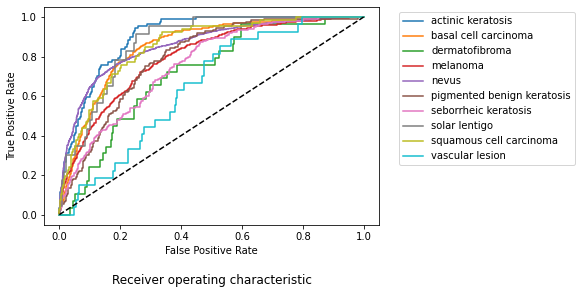

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

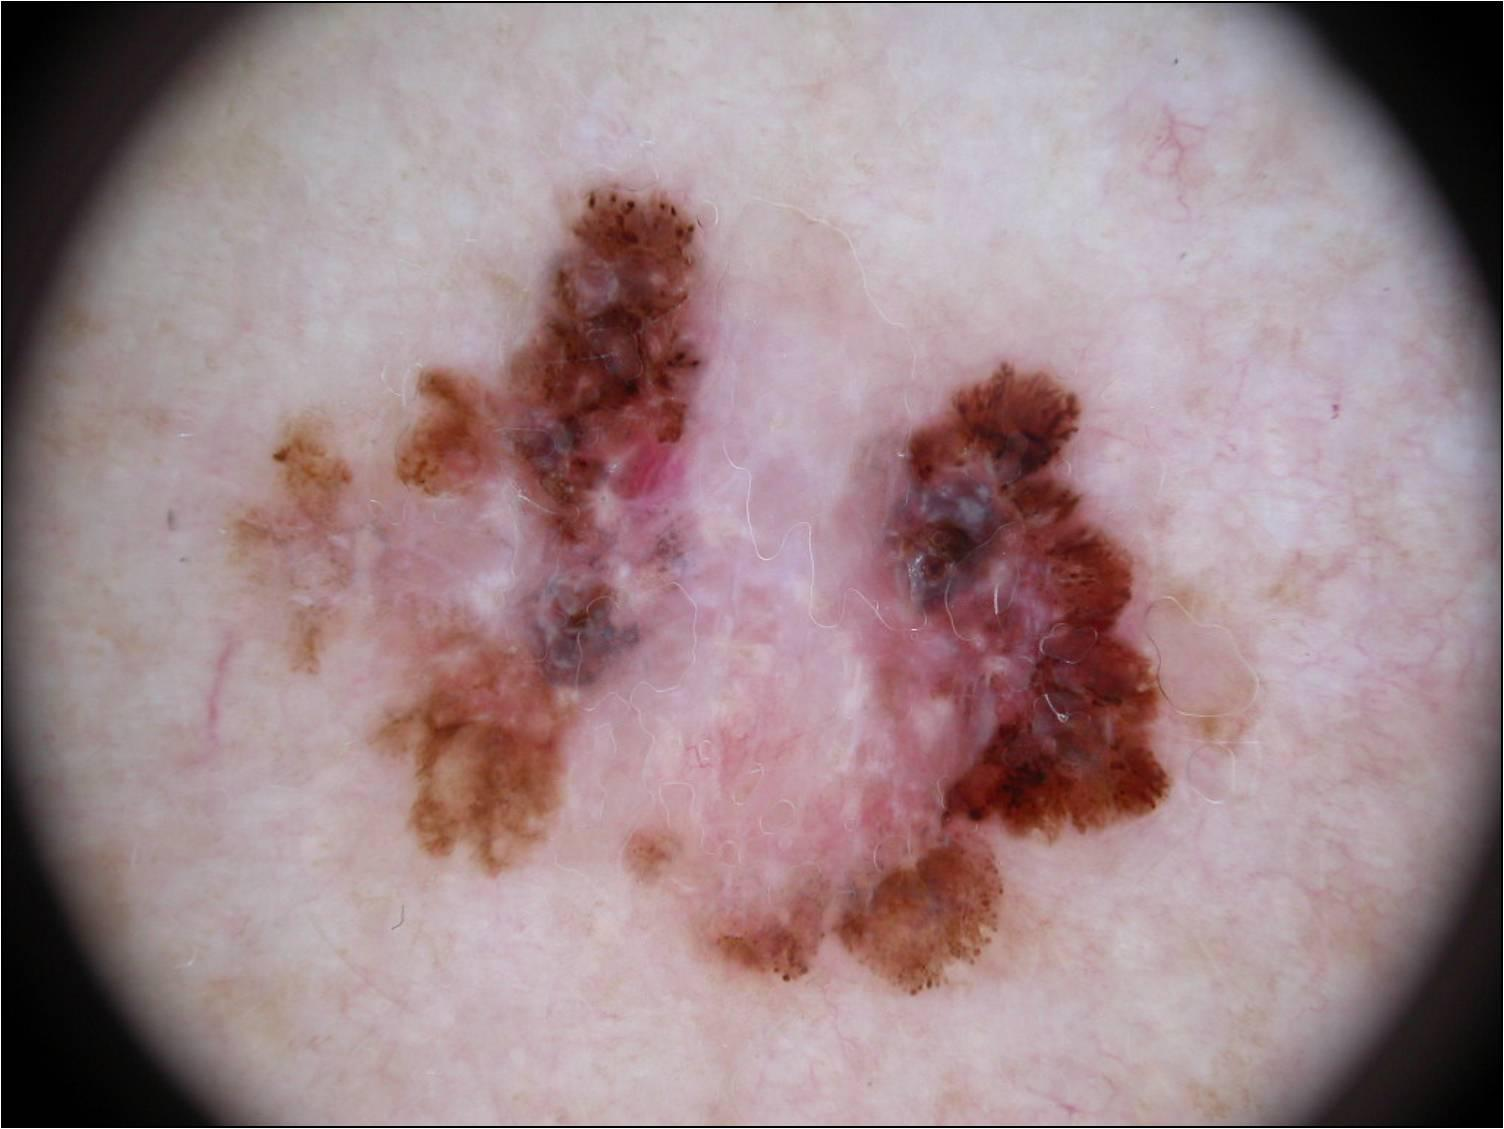

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'block14_sepconv2')

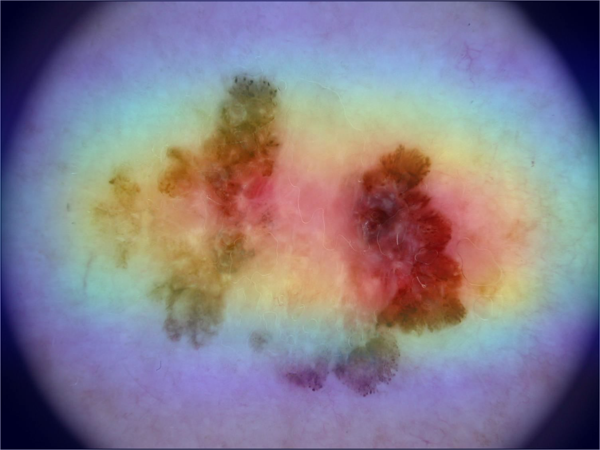

In [21]:
display_gradcam(melanoma_im_path, heatmap)